# Introduction

This notebook will look at some aspects of the Baselines which we will challenge with.

As other Kaggle competitors already have shown, just betting on the favorite / the player with odds of a favorite, does not push the ROI very well. 

I'll try to find a strategy that makes (if possible) a no-profit / no-loss line as benchmark. After that I'll try to make a model based prediction to improve the ROI as good as possible. 

## Taxes and profits
Due to the fact that I live in Germany I have to take into account that a tax of 5% at each bet has to be paid. This decreases the profitability and rises the benchmark to be reached. I don't know if and how there are similar taxes in other countries, I'll drag it along the code.

For comparability issues we'll bet 1 unit of money whichever currency and I don't think that it matters if it is € or $.



In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

import pandas as pd
from datetime import datetime,timedelta


os.chdir('Python')
from eda_functions import *
from utilities import *
os.chdir('../')

import warnings
warnings.filterwarnings(action='once')

## Effective odds / rates

In [13]:
# amount of tax paid on each bet
tax = 0.05

# nominal rates / odds
rates_nom = np.linspace(1,2.5,1000)

# effective rates / odds considering the tax
rates_eff = rates_nom * (1-tax)

# minimum nominal rate to get at least a of 1
# this can be seen as break even value. Below this value we make loss even we won.
rate_eff_1 = 1/(1-tax)

# minimal percentage of winning bets vs. rates for no long term lose.
min_win_0= (1/rates_nom)*100
min_win_0_eff= (1/rates_eff)*100

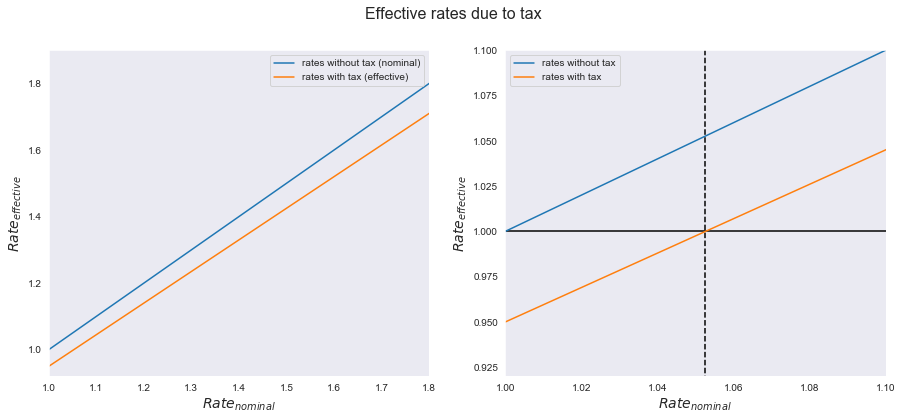

In [14]:
plot_rates_with_tax(rates_nom, rates_eff, rate_eff_1) # see my_plot_func.py

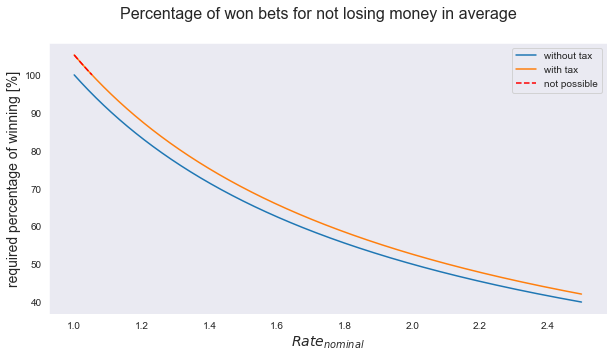

In [15]:
plot_min_perc_winning(rates_nom, min_win_0,min_win_0_eff) # see my_plot_func.py

As you can see, the tax matters not only a bit. It distorts straight average strategies. It also disturbs the balance between winning rate, odds, risk and confidence if an outcome appears. There is a threshold of odds / rates for the winning zone because treasury aggrevates the success in betting.

So I would expect that it makes no sense to bet on *Nadal* due to rather low odds (1.01) even it is nearly obvious that he wins.

**Note:** I observed that it looks like some bookmakers offer betting with a wager of 50 cent. The deducted tax is "only" 2 cent due to rounding issues. This reduces the tax to 4%. I don't estimate that this fact matter to the way reaching a significant gain. 

# Loading Data
**Note:** For preparing data the first part of [1_data_and_features.ipynb](1_data_and_features.ipynb) has to be ran.

In [16]:
data = load("Generated Data/atp_data")

/Users/mareknowaczewski/nf-may20/cap_new_2/capstone/Python/utilities.py:13: ResourceWarning: unclosed file <_io.BufferedReader name='Generated Data/atp_data.p'>
  obj=pickle.load( open( name+".p", "rb" ) )


The older data has few odds, so we will drop it for now and reduce a bit the amount of samples.
We will start in 2005.

In [17]:
beg_year = 2005
dat = data[(data.Date.dt.year >= beg_year)]

In [18]:
dat['elo_diff'] = dat.elo_winner - dat.elo_loser
dat['rank_diff'] = dat.LRank - dat.WRank
dat['smaller_ps'] = dat[['PSL','PSW']].min(axis=1)
dat['smaller_b365'] = dat[['B365W','B365L']].min(axis=1)

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Better player?
How to figure out the better player where we are confident that he wins?

Have a look on players that have a better elo-score **AND** a better ATP-ranking.

<>:12: DeprecationWarning: invalid escape sequence \D


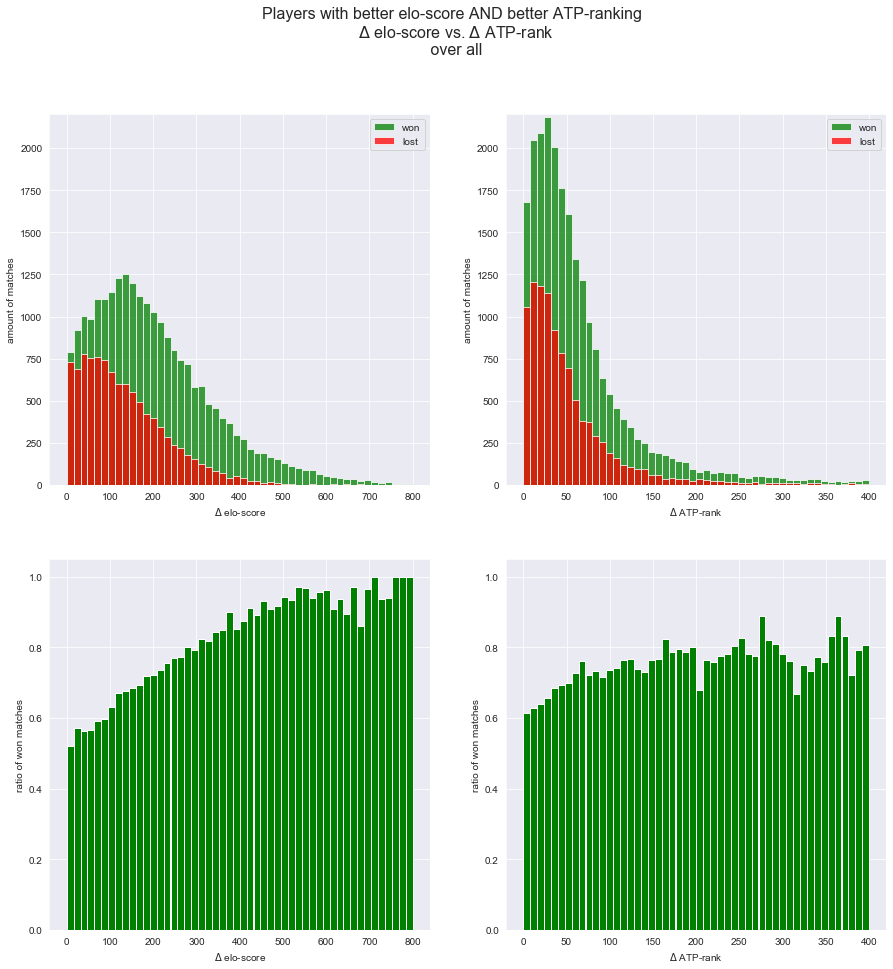

In [9]:
thr = 1.0       # Threshold of odds that should be considered. Minimum od odds
limit = 200     # limit the maximum of odds, 200 = unlimited
diff_rank = 0   # Minimum difference in Rank
diff_elo = 0    # minimum differende in elo-score

#k1 = dat[(dat.elo_winner>dat.elo_loser+diff_elo) & (dat.WRank<dat.LRank-diff_rank) & (dat.B365W>thr) & (dat.B365W<limit) & (dat.Round == rnd)]
#k2 = dat[(dat.elo_winner<dat.elo_loser-diff_elo) & (dat.WRank>dat.LRank+diff_rank) & (dat.B365L>thr) & (dat.B365L<limit) & (dat.Round == rnd)]

k1 = dat[(dat.elo_winner>dat.elo_loser+diff_elo) & (dat.WRank<dat.LRank-diff_rank) & (dat.B365W>thr) & (dat.B365W<limit) ]
k2 = dat[(dat.elo_winner<dat.elo_loser-diff_elo) & (dat.WRank>dat.LRank+diff_rank) & (dat.B365L>thr) & (dat.B365L<limit) ]

title = 'Players with better elo-score AND better ATP-ranking \n $\Delta$ elo-score vs. $\Delta$ ATP-rank \n over all'
plot_delta_hisograms(k1,k2, 2200, title)

As you see in the figure above the differene of the elo-score promises a bit more chance that the player wins and that the much higher rank in the ATP list. The higher the difference of the elo-score the higher the probability to win. But according to this fact the odds will also fall towards the winner and the amount of such matches falls. 

On the one hand we could say, "So what..." let's bet just on the few nearly sure matches, just pick the matches above $\Delta$-elo 400, but on the other hand we have to keep in mind in our case the tax and the needed ratio of wins at all.

Let's see next if we want a minimum of odds. At least 1.06 for the tax and further 0.02 for our deposit, so 1.08.

/Users/mareknowaczewski/nf-may20/cap_new_2/capstone/Python/my_plot_func.py:84: RuntimeWarning: invalid value encountered in true_divide
  x3 = n/(n+n2)


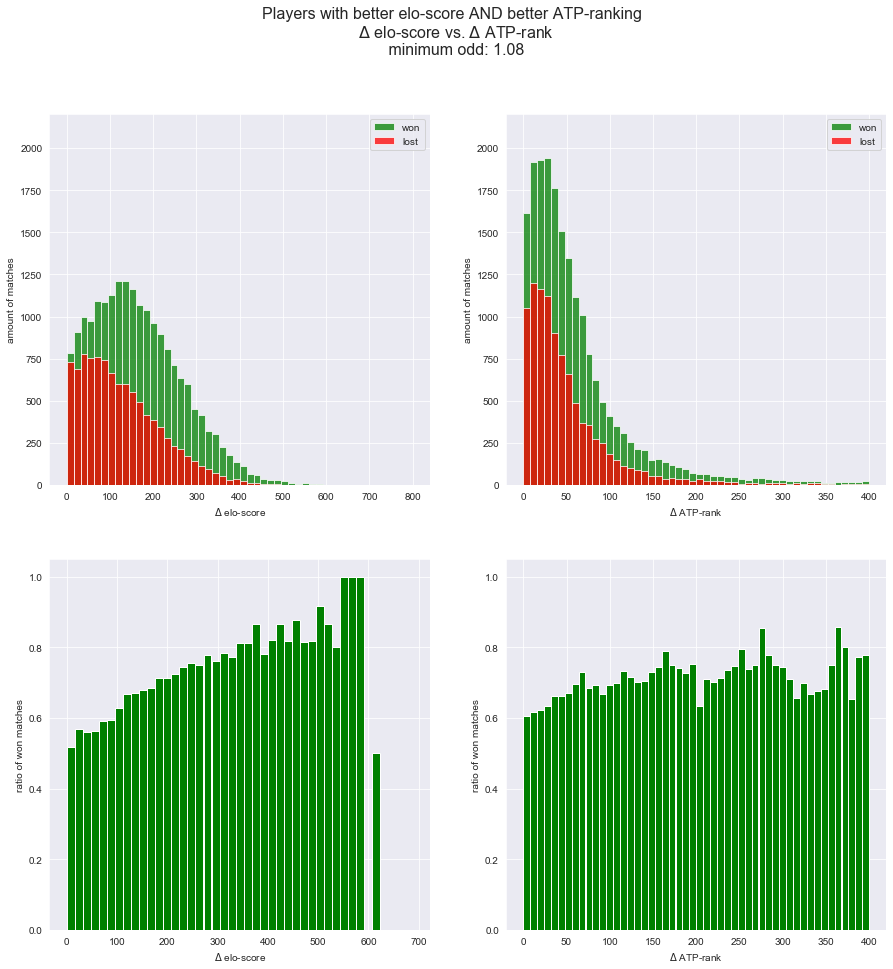

In [10]:
thr = 1.08       # Threshold of odds that should be considered. Minimum od odds
limit = 200     # limit the maximum of odds, 200 = unlimited
diff_rank = 0   # Minimum difference in Rank
diff_elo = 0    # minimum differende in elo-score

#k1 = dat[(dat.elo_winner>dat.elo_loser+diff_elo) & (dat.WRank<dat.LRank-diff_rank) & (dat.B365W>thr) & (dat.B365W<limit) & (dat.Round == rnd)]
#k2 = dat[(dat.elo_winner<dat.elo_loser-diff_elo) & (dat.WRank>dat.LRank+diff_rank) & (dat.B365L>thr) & (dat.B365L<limit) & (dat.Round == rnd)]

k1 = dat[(dat.elo_winner>dat.elo_loser+diff_elo) & (dat.WRank<dat.LRank-diff_rank) & (dat.B365W>thr) & (dat.B365W<limit) ]
k2 = dat[(dat.elo_winner<dat.elo_loser-diff_elo) & (dat.WRank>dat.LRank+diff_rank) & (dat.B365L>thr) & (dat.B365L<limit) ]

title = f'Players with better elo-score AND better ATP-ranking \n $\Delta$ elo-score vs. $\Delta$ ATP-rank \n minimum odd: {thr}'
plot_delta_hisograms(k1,k2, 2200, title)

As you see this strategy wouldn't work properly, because very few matches let to bet over years. The ROI including the losses wouldn't look glorious also, I think. 

Let's have look how it is if we only consider matches of the *$1^{st}$ Round*, the differenc between the competitors should be larger. And if a weak player comes to the finals, he had a good run or a lucky week.

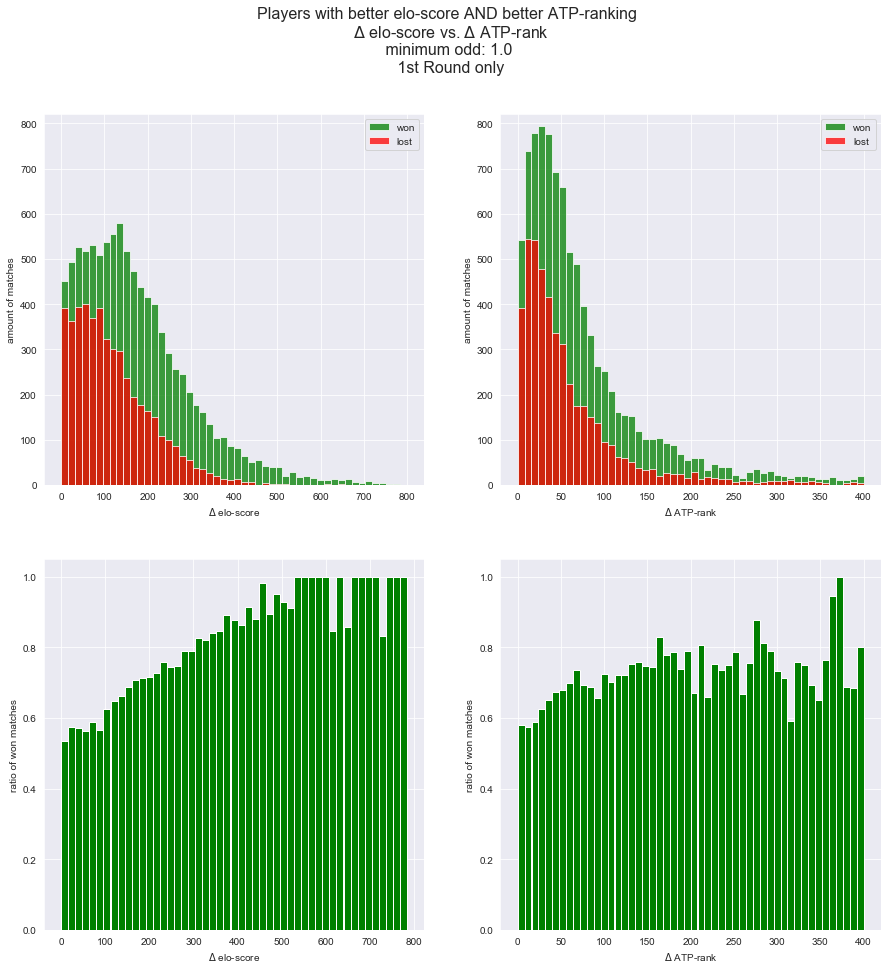

In [11]:
thr = 1.0       # Threshold of odds that should be considered. Minimum od odds
limit = 200     # limit the maximum of odds, 200 = unlimited
diff_rank = 0   # Minimum difference in Rank
diff_elo = 0    # minimum differende in elo-score
rnd = '1st Round' # Round

k1 = dat[(dat.elo_winner>dat.elo_loser+diff_elo) & (dat.WRank<dat.LRank-diff_rank) & (dat.B365W>thr) & (dat.B365W<limit) & (dat.Round == rnd)]
k2 = dat[(dat.elo_winner<dat.elo_loser-diff_elo) & (dat.WRank>dat.LRank+diff_rank) & (dat.B365L>thr) & (dat.B365L<limit) & (dat.Round == rnd)]

#k1 = dat[(dat.elo_winner>dat.elo_loser+diff_elo) & (dat.WRank<dat.LRank-diff_rank) & (dat.B365W>thr) & (dat.B365W<limit) ]
#k2 = dat[(dat.elo_winner<dat.elo_loser-diff_elo) & (dat.WRank>dat.LRank+diff_rank) & (dat.B365L>thr) & (dat.B365L<limit) ]

title = f'Players with better elo-score AND better ATP-ranking \n $\Delta$ elo-score vs. $\Delta$ ATP-rank \n minimum odd: {thr} \n 1st Round only'
plot_delta_hisograms(k1,k2, 820, title)

So this look ok, due to the fact that the ratio of won matches is a bit higher than before, **but** we left the minimum odds at 1.0! **And** the total amount of matches decreased, see the scale of the upper graphs.

**Conclusion:** The elo-score is the better indicator than the ATP-ranking. But it don't helps us to win in th end. We need a bit more of confidence.

# Just betting on the better player with high odds

What happens if we bet on the better player who might be underestimated by the odds we want to earn a bit.

In [58]:
#df_new = dat[dat.Round == '1st Round']
df_new = dat
iis_p =[]
iis_n =[]
gain = 0
gain_list =[0]
elo = 125
rk = 100
thr = 1.0

for i in range(df_new.shape[0]):
    d = df_new.iloc[i].elo_diff
    dr = df_new.iloc[i].rank_diff
    oddW = df_new.iloc[i].B365W
    oddL = df_new.iloc[i].B365L
    if d < (-elo) and dr > rk and oddW >= thr:
        gain +=  (df_new.iloc[i].B365W-1)
        gain_list.append(gain)
        iis_p.append(i)
    elif d > (elo) and dr < (-rk) and oddL >= thr:
        gain -= 1
        gain_list.append(gain)
        iis_n.append(i)
    else:
        pass

In [71]:
#df_new = dat[dat.Round == '1st Round']
df_new = dat
iis_p =[]
iis_n =[]
gain = 0
gain_list =[0]
elo = 0
rk = 0
thr = 1.0

for i in range(df_new.shape[0]):
    d = df_new.iloc[i].elo_diff
    dr = df_new.iloc[i].rank_diff
    oddW = df_new.iloc[i].B365W
    oddL = df_new.iloc[i].B365L
    if d > (elo) and dr > rk and oddW >= thr:
        gain +=  (df_new.iloc[i].B365W-1)
        gain_list.append(gain)
        iis_p.append(i)
    elif d < (-elo) and dr < (-rk) and oddL >= thr:
        gain -= 1
        gain_list.append(gain)
        iis_n.append(i)
    else:
        pass


<>:5: DeprecationWarning: invalid escape sequence \D


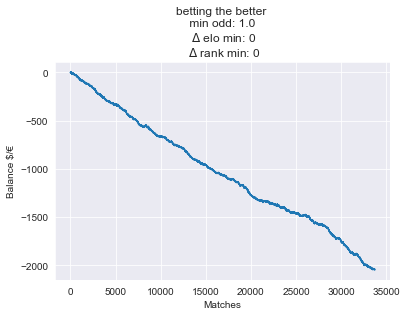

In [72]:
plt.plot(gain_list)
ax = plt.gca()
ax.set_xlabel('Matches');
ax.set_ylabel('Balance $/€');
ax.set_title(f'betting the better \n min odd: {thr} \n $\Delta$ elo min: {elo} \n $\Delta$ rank min: {rk}');

With a proper ROI in the beginning the gain got lost.
In the end we will lose! The higher the threshold the fewer the matches.

**Conclusion:** We need a bit of help of machine learning to become more confident that matches are won where we bet on.

# Waiting for revision
On the following code I'll have to work on. There are some bugs to treat.

In [31]:
def gain_perc_b365(dat, tax=0.05, round_ = None, limit = 200, threshold = None, diff_elo = 0, diff_rank = 0):
    '''
    Gives back the avarage performace of betting. Staight betting on the player with the better elo-score AND the better Rank.
    
    dat: the given DataFrame.
    tax: tax rate to be considered directly on the wager.
    round_: index of list. selecting the round to be inspected. If None then all rounds are considered.
    ['1st Round', '2nd Round','3rd Round', '4th Round', 'Quarterfinals', 'Semifinals', 'The Final']
    limit: maximum odds to be considered
    thr: minimum odd as theshold for betting. If 'None' then threshold calculated by tax if set.
    diff_elo: how much higher should the elo-score at least be.
    diff_rank: how much higher should the rank at least be
    
    return:
    gain: average performance
    (n_bets: number of bets)
    (n_good_bets: number of sucessful bets)
    '''
    #if therhold == None:
    #    thr = 1/(1-tax)
    #else:
    #    thr = threshold
    thr = 1/(1-tax) if threshold == None else threshold
    
    rounds = pd.Series(['1st Round', '2nd Round','3rd Round', '4th Round', 'Quarterfinals', 'Semifinals', 'The Final'])
    
    round_x = None if round_ == None else list([round_]) if type(round_) == int else round_
    rnd = list(rounds) if round_x == None else list(rounds[round_x])
    
    # amount of successfull bets
    k1 = len(dat.B365W[(dat.elo_winner>dat.elo_loser+diff_elo) & (dat.WRank<dat.LRank-diff_rank) & (dat.B365W>thr) & (dat.B365W<limit) & (dat.Round.isin(rnd))])
    #k1 = len(dat.B365W[(dat.elo_winner>dat.elo_loser+diff_elo)  & (dat.B365W>thr) & (dat.B365W<limit) & (dat.Round.isin(rnd))])
    # amount of failed bets    
    k2 = len(dat.B365W[(dat.elo_winner<dat.elo_loser-diff_elo) & (dat.WRank>dat.LRank+diff_rank) & (dat.B365L>thr) & (dat.B365L<limit) & (dat.Round.isin(rnd))])
    #k2 = len(dat.B365W[(dat.elo_winner<dat.elo_loser-diff_elo)  & (dat.B365L>thr) & (dat.B365L<limit) & (dat.Round.isin(rnd))])
    # earnings absolute
    g = (dat.B365W[(dat.elo_winner>dat.elo_loser+diff_elo)& (dat.WRank<dat.LRank-diff_rank) & (dat.B365W>thr) & (dat.B365W<limit)& (dat.Round.isin(rnd))]*(1-tax)).sum()
    #g = (dat.B365W[(dat.elo_winner>dat.elo_loser+diff_elo) & (dat.B365W>thr) & (dat.B365W<limit)& (dat.Round.isin(rnd))]*(1-tax)).sum()
    # earnings percentage of all bets
    k = ((dat.B365W[(dat.elo_winner>dat.elo_loser+diff_elo)& (dat.WRank<dat.LRank-diff_rank) & (dat.B365W>thr) & (dat.Round.isin(rnd))]*(1-tax)).sum()-(k1+k2))/(k1+k2)
    #k = ((dat.B365W[(dat.elo_winner>dat.elo_loser+diff_elo) & (dat.B365W>thr) & (dat.Round.isin(rnd))]*(1-tax)).sum()-(k1+k2))/(k1+k2)
    
    return k, k1, (k1 + k2), g
    #return k

In [43]:
beg=datetime(2011,1,1) 
#beg=datetime(2008,1,1) 
end=data.Date.iloc[-1]
end=datetime(2018,3,4)
indices=data[(data.Date>beg)&(data.Date<=end)].index
data_sel=data[["B365W","B365L","PSW","PSL","WRank","LRank"]]
data_sel=data.iloc[indices,:]
#data_sel=data_sel.iloc[[0,1,2],:]
data_sel.dropna(inplace = True)
print("Number of matches during this period : "+str(len(data_sel)))

Number of matches during this period : 18772


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [32]:
data_sel=data[["B365W","B365L","PSW","PSL","WRank","LRank","Date"]]
#data_sel=data.iloc[indices,:]
#data_sel=data_sel.iloc[[0,1,2],:]
data_sel.dropna(inplace = True)

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [44]:
x = np.linspace(0, 200, 40)
y = np.linspace(0, 120, 24)

X, Y = np.meshgrid(x, y)

In [45]:
Y.shape
ZR = np.zeros(X.shape)
Z1R = np.zeros(X.shape)
Z2R = np.zeros(X.shape)
Z3R = np.zeros(X.shape)

for i,elo in enumerate(x):
    for j, rank in enumerate(y):
        tmp = gain_perc_b365(data_sel, diff_elo = elo, diff_rank = rank, round_ = 0)
        #tmp = gain_perc_b365(dat, diff_elo = elo, diff_rank = rank, round_ = None)
        ZR[j,i] = tmp[0]
        Z1R[j,i] = tmp[1]
        Z2R[j,i] = tmp[2]
        Z3R[j,i] = tmp[3]



ZR = ZR*100
Z4R = Z3R - Z2R

In [35]:
class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s

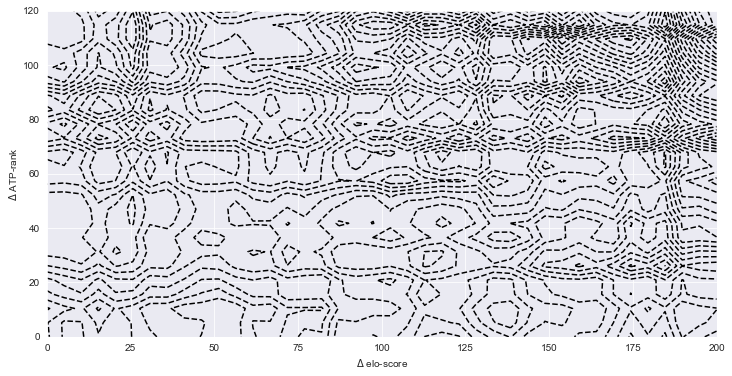

In [46]:
fig, ax = plt.subplots(figsize = (12,6))
CS = ax.contour(X, Y, ZR, 30, colors='black')
'''
# Recast levels to new class
CS.levels = [nf(val) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'
'''
    
#ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
'''
CS3 = ax.contourf(X, Y, Z4R, 100, cmap='RdYlGn', alpha=0.5)
cb = fig.colorbar(CS3)
cb.set_label('Absolute gain, wager 1 € per bet')
CS3.set_clim(-1000,1000)
'''
ax.set_xlabel('$\Delta$ elo-score');
ax.set_ylabel('$\Delta$ ATP-rank');

In [30]:
CS.levels

array([-12.35, -12.3 , -12.25, -12.2 , -12.15, -12.1 , -12.05, -12.  ,
       -11.95, -11.9 , -11.85, -11.8 , -11.75, -11.7 , -11.65, -11.6 ,
       -11.55, -11.5 , -11.45, -11.4 , -11.35, -11.3 , -11.25, -11.2 ,
       -11.15, -11.1 , -11.05, -11.  , -10.95, -10.9 , -10.85])

In [60]:
#check_df = data_sel[(data_sel.Date == datetime(2018,))]
dat.tail()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo,elo_diff,rank_diff,smaller_ps,smaller_b365
54903,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Nadal R.,...,3.26,1.44,2.75,2166.698440,1943.454123,0.783316,223.244318,5,1.39,1.44
54904,66,London,Masters Cup,2019-11-15,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,...,1.79,1.90,1.90,1871.969248,1993.307883,0.332149,-121.338635,-3,1.79,1.90
54905,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Tsitsipas S.,...,1.33,3.50,1.30,1936.520243,2112.927830,0.265908,-176.407587,-3,1.33,1.30
54906,66,London,Masters Cup,2019-11-16,Masters Cup,Indoor,Hard,Semifinals,3,Thiem D.,...,2.10,1.80,2.00,2009.920207,1893.340479,0.661746,116.579728,2,1.84,1.80
54907,66,London,Masters Cup,2019-11-17,Masters Cup,Indoor,Hard,The Final,3,Tsitsipas S.,...,1.93,2.00,1.80,1960.011185,2020.744320,0.413477,-60.733135,-1,1.93,1.80


In [66]:
dat.loc[54903]

ATP                              66
Location                     London
Tournament              Masters Cup
Date            2019-11-15 00:00:00
Series                  Masters Cup
Court                        Indoor
Surface                        Hard
Round                   Round Robin
Best of                           3
Winner                     Nadal R.
Loser                  Tsitsipas S.
WRank                             1
LRank                             6
Wsets                             2
Lsets                             1
Comment                   Completed
PSW                            1.39
PSL                            3.26
B365W                          1.44
B365L                          2.75
elo_winner                   2166.7
elo_loser                   1943.45
proba_elo                  0.783316
elo_diff                    223.244
rank_diff                         5
smaller_ps                     1.39
smaller_b365                   1.44
Name: 54903, dtype: object

In [48]:
gain_perc_b365(data_sel, diff_elo = 500, diff_rank = 0)

(-0.07696538461538482, 116, 130, 119.99449999999997)

In [53]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40390 entries, 14518 to 54907
Data columns (total 27 columns):
ATP             40390 non-null int64
Location        40390 non-null object
Tournament      40390 non-null object
Date            40390 non-null datetime64[ns]
Series          40390 non-null object
Court           40390 non-null object
Surface         40390 non-null object
Round           40390 non-null object
Best of         40390 non-null int64
Winner          40390 non-null object
Loser           40390 non-null object
WRank           40390 non-null int64
LRank           40390 non-null int64
Wsets           40160 non-null float64
Lsets           40159 non-null float64
Comment         40390 non-null object
PSW             37240 non-null float64
PSL             37240 non-null float64
B365W           39843 non-null float64
B365L           39866 non-null float64
elo_winner      40390 non-null float64
elo_loser       40390 non-null float64
proba_elo       40390 non-null float64
